# Automatic chord recognition 
### George Tzanetakis, University of Victoria

In this notebook, we explore different approaches to automatic chord recognition. 
We will be using the Beatles corpus which was one of the first datasets that 
was annotated with chords. As a representation we will use a beat-synchronous chroma representation. 

First we load a collection of about 180 audio recordings by the Beatles. Historically this was one of the first collections of music that was annotated with chords and it has been used for training and evaluation of automatic chord recognition systems for years. It is relatively small and fortunately there are larger collections that can be used but it will serve for illustrating the main ideas behind automatic chord recognition. 


In [3]:
import glob 
import IPython.display as ipd
import os
import numpy as np
import warnings
import pandas as pd
import scipy as sp


from sklearn import svm, metrics
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    import librosa

    
fnames = glob.glob('/Users/georgetzanetakis/data/sound/beatles/*/*.mono.wav')
fnames.sort()
print('Number of files %d' % len(fnames))

label_files = glob.glob('/Users/georgetzanetakis/data/sound/beatles/annotations/chordlab/The Beatles/*/*.lab')
label_files.sort()
del(label_files[149])



Number of files 179


Let's listen to one of the files. 

In [4]:
audio, srate = librosa.load('/Users/georgetzanetakis/data/sound/beatles/10CD1_-_The_Beatles/CD1_-_11_-_Black_Bird.wav')
ipd.Audio(audio, rate=srate)

In the next cell, each audio file is loaded and a beat syncrhonous chroma representation is calculated - notice the significant reduction in terms of the chromagram matrix size after the beat-synchronous aggregation is performed.  The corresponding files with the chord annotations are read and time-aligned to the beat-synchronous chroma vectors. Finally, all the information is stored in a Pandas datafarame. 


In [5]:
dataframe_list = [] 
chroma_names = ['C', 'C#', 'D', "D#", 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']   
   
for (i,(fname,lname)) in enumerate(zip(fnames,label_files)): 
    print('Processing %d: %s' % (i,os.path.basename(fname)))
    audio, srate = librosa.load(fname)
    chromagram = librosa.feature.chroma_cqt(y=audio, sr=srate)
    print('Chromagram shape: (%d,%d)' % chromagram.shape)
    tempo, beats = librosa.beat.beat_track(y=audio, sr=srate,trim=False)
    beat_times = librosa.frames_to_time(beats, sr=srate)
    chromagram_beats = librosa.util.sync(chromagram, beats, aggregate=np.median)
    chromagram_beats_smooth = sp.ndimage.median_filter(chromagram_beats, size=(1, 9))    
    
    print('Beat synchronous chromagram shape: (%d,%d)' % chromagram_beats.shape)
    lfile = open(lname, 'r')
    label_lines = lfile.readlines()
    chord_segments = [] 
    for line in label_lines: 
        line_list = line.split()
        start = float(line_list[0])
        end = float(line_list[1])
        label = line_list[2]
        chord_segments.append([start, end, label])
    chord_labels = [] 
    for beat in beat_times: 
        for s in chord_segments: 
            label = chord_segments[-1][2]
            if (beat < s[1]):
                label = s[2] 
                break
        chord_labels.append(label)
    if (len(chord_labels) != chromagram_beats.shape[1]): 
        chord_labels.append(label)   
    lfile.close()
    

    features_df = pd.DataFrame(data=chromagram_beats.T, columns = chroma_names)
    features_df['chord_label'] = chord_labels 
    features_df['track'] = [os.path.basename(fname)] * len(chord_labels)
    dataframe_list.append(features_df)
    
    

Processing 0: 01_-_I_Saw_Her_Standing_There.mono.wav
Chromagram shape: (12,7572)
Beat synchronous chromagram shape: (12,456)
Processing 1: 02_-_Misery.mono.wav
Chromagram shape: (12,4745)
Beat synchronous chromagram shape: (12,235)
Processing 2: 03_-_Anna_(Go_To_Him).mono.wav
Chromagram shape: (12,7648)
Beat synchronous chromagram shape: (12,322)
Processing 3: 04_-_Chains.mono.wav
Chromagram shape: (12,6309)
Beat synchronous chromagram shape: (12,309)
Processing 4: 05_-_Boys.mono.wav
Chromagram shape: (12,6353)
Beat synchronous chromagram shape: (12,342)
Processing 5: 06_-_Ask_Me_Why.mono.wav
Chromagram shape: (12,6364)
Beat synchronous chromagram shape: (12,321)
Processing 6: 07_-_Please_Please_Me.mono.wav
Chromagram shape: (12,5272)
Beat synchronous chromagram shape: (12,273)
Processing 7: 08_-_Love_Me_Do.mono.wav
Chromagram shape: (12,3208)
Beat synchronous chromagram shape: (12,92)
Processing 8: 09_-_P._S._I_Love_You.mono.wav
Chromagram shape: (12,5415)
Beat synchronous chromagram 

Beat synchronous chromagram shape: (12,298)
Processing 70: 02_-_Norwegian_Wood_(This_Bird_Has_Flown).mono.wav
Chromagram shape: (12,5402)
Beat synchronous chromagram shape: (12,362)
Processing 71: 03_-_You_Wont_See_Me.mono.wav
Chromagram shape: (12,8726)
Beat synchronous chromagram shape: (12,385)
Processing 72: 04_-_Nowhere_Man.mono.wav
Chromagram shape: (12,7077)
Beat synchronous chromagram shape: (12,324)
Processing 73: 05_-_Think_For_Yourself.mono.wav
Chromagram shape: (12,6001)
Beat synchronous chromagram shape: (12,297)
Processing 74: 06_-_The_Word.mono.wav
Chromagram shape: (12,7050)
Beat synchronous chromagram shape: (12,328)
Processing 75: 07_-_Michelle.mono.wav
Chromagram shape: (12,6993)
Beat synchronous chromagram shape: (12,310)
Processing 76: 08_-_What_Goes_On.mono.wav
Chromagram shape: (12,7356)
Beat synchronous chromagram shape: (12,266)
Processing 77: 09_-_Girl.mono.wav
Chromagram shape: (12,6627)
Beat synchronous chromagram shape: (12,239)
Processing 78: 10_-_Im_Looki

Chromagram shape: (12,7503)
Beat synchronous chromagram shape: (12,253)
Processing 138: CD2_-_01_-_Birthday.mono.wav
Chromagram shape: (12,7016)
Beat synchronous chromagram shape: (12,373)
Processing 139: CD2_-_02_-_Yer_Blues.mono.wav
Chromagram shape: (12,10384)
Beat synchronous chromagram shape: (12,619)
Processing 140: CD2_-_03_-_Mother_Natures_Son.mono.wav
Chromagram shape: (12,7237)
Beat synchronous chromagram shape: (12,469)
Processing 141: CD2_-_04_-_Everybodys_Got_Something_To_Hide_Except_Me_and_M.mono.wav
Chromagram shape: (12,6237)
Beat synchronous chromagram shape: (12,285)
Processing 142: CD2_-_05_-_Sexy_Sadie.mono.wav
Chromagram shape: (12,8413)
Beat synchronous chromagram shape: (12,487)
Processing 143: CD2_-_06_-_Helter_Skelter.mono.wav
Chromagram shape: (12,11614)
Beat synchronous chromagram shape: (12,753)
Processing 144: CD2_-_07_-_Long_Long_Long.mono.wav
Chromagram shape: (12,7939)
Beat synchronous chromagram shape: (12,319)
Processing 145: CD2_-_08_-_Revolution_1.mo

The original annotated chords of the Beatles dataset are based on a large chord vocabulary with 402 different chord types. We can map them to 24 major and minor chords that together with the no chord label N results in a vocabulary of 25 chord types. After remapping we write the resulting Pandas dataframe as a .csv file. 

In [13]:
beatles_df = pd.concat(dataframe_list)
print(beatles_df)
print(len(beatles_df['chord_label'].unique()))

def map_chord_labels(chord_labels):
    mapped_chord_labels = [] 
    for c in chord_labels:
        mc = c
        i = c.find(':')
        if (i==-1): # major tried shorthand 
            k = c.find('/')
            if (k==-1):
                mc = c + ':maj'
            else:
                mc = c[0:k] + ':maj'
        else:
            if (c[i+1] == 'm'):
                mc = c[0:i+4]
            else:
                mc = c[0:i] + ':maj'

        mc = mc.replace('Db', 'C#')
        mc = mc.replace('Gb', 'F#')
        mc = mc.replace('N:maj', 'N')
        mc = mc.replace('X:maj', 'N')
        mc = mc.replace('Cb', 'B')
        mc = mc.replace('Fb', 'E')
        mc = mc.replace('E#', 'F')
        mc = mc.replace('Ab', 'G#')
        mc = mc.replace('Bb', 'A#')
        mc = mc.replace('Eb', 'D#')
        mc = mc.replace('B#', 'C')
        
        
        # print(c, mc, i)
        mapped_chord_labels.append(mc)

    return mapped_chord_labels

chord_labels = beatles_df['chord_label']
new_chord_labels = map_chord_labels(chord_labels)
beatles_df['chord_label'] = new_chord_labels
beatles_df.to_csv('beatles.csv', index=False)

            C        C#         D        D#         E         F        F#  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.655590  0.460786  0.378427  0.419906  0.431711  0.498811  0.727700   
2    0.349151  0.243264  0.193173  0.138386  0.120441  0.207318  0.424048   
3    0.416464  0.458166  0.414773  0.195341  0.185102  0.142300  0.340324   
4    0.452033  0.633935  0.613339  0.288613  0.157931  0.192926  0.309766   
..        ...       ...       ...       ...       ...       ...       ...   
378  0.277589  0.394407  0.756025  0.699669  0.505264  0.546767  0.624092   
379  0.342548  0.342332  0.581123  0.492612  0.404080  0.640369  0.613329   
380  0.361689  0.420222  1.000000  0.848327  0.343394  0.319644  0.449698   
381  0.359918  0.464044  1.000000  0.831451  0.358112  0.358499  0.506410   
382  0.346121  0.431855  0.494304  0.538424  0.369806  0.400397  0.485221   

            G        G#         A        A#         B chord_label  \
0    0

Now that we have all the beat-synchronous features and chord labels for the Beatles dataset we can look at different ways of performing automatic chord recognition. 

In [15]:

beatles_df = pd.read_csv('beatles.csv')
chord_labels = beatles_df['chord_label']

In order to easier perform different types of smoothing on the chord predictions the string chord labels need to be converted to numeric chord labels. We can also look at the frequencies of the different chord types in our dataset. The variable X is used to store the beat-synchronous features and the variable y has the new numeric chord labels. 

In [17]:
X = beatles_df.iloc[:,range(0,12)].values
print(beatles_df['chord_label'].value_counts())
y = beatles_df['chord_label'].to_list()


chord_number = {
'C:maj': 0,
'C#:maj': 1, 
'D:maj': 2, 
'D#:maj': 3, 
'E:maj': 4,
'F:maj': 5,
'F#:maj': 6, 
'G:maj': 7, 
'G#:maj': 8, 
'A:maj': 9,
'A#:maj': 10,
'B:maj': 11, 
'C:min': 12,
'C#:min': 13, 
'D:min': 14, 
'D#:min': 15, 
'E:min': 16,
'F:min': 17,
'F#:min': 18, 
'G:min': 19, 
'G#:min': 20, 
'A:min': 21,
'A#:min': 22,
'B:min': 23, 
'N': 24 
}

y = [chord_number[c] for c in y]



A:maj     8504
E:maj     7394
D:maj     7321
G:maj     7244
C:maj     5468
F:maj     2560
B:maj     2523
A:min     2324
D:min     1631
A#:maj    1575
E:min     1575
F#:min    1411
C#:maj    1348
B:min     1324
F#:maj    1211
N          932
C#:min     899
D#:maj     899
G#:maj     880
F:min      646
G:min      607
C:min      538
G#:min     294
A#:min     228
D#:min     144
Name: chord_label, dtype: int64


The first approach we will try is a very simple template-based approach. Typically in such approaches there is a template of ones and zeros (or floating-point values) for each chord type that is multiplied with the chroma representation for each beat. The one with the highest value is selected as the predicted chord type. In our case we will follow an even simpler approach. The highest chroma value is selected as the chord root and then we examine and compare the third above the root. Depending on the relative strength of the minor and major third, the resulting chord is labeled as a major or minor. Although simple this approach performs significantly better than random. 

In [22]:
import random

predicted_template = []
predicted_random = []
for chroma in X: 
    i = np.argmax(chroma)
    root = chroma_names[np.argmax(chroma)]
    minor_third_strength = chroma[(i + 3)%12]
    major_third_strength = chroma[(i + 4)%12]
    if (major_third_strength >= minor_third_strength): 
        name = root + ':maj'
    else: 
        name = root + ':min'
    predicted_template.append(chord_number[name])
    predicted_random.append(random.randint(0,25))
    
print("Random classification accuracy:\n%s\n" % metrics.accuracy_score(y, predicted_random))
print("Template classification accuracy:\n%s\n" % metrics.accuracy_score(y, predicted_template))


Random classification accuracy:
0.03781102891728312

Template classification accuracy:
0.3488231338264963



An alternative to a template-based approach is to use a machine learning approach. First we will try creating a typical classifier that takes as input a beat-synchronous chroma vector and predicts the chord type. We can calculate the classification accuracy and confusion matrix of this classifier. As we are mostly concerned in showing the main ideas we will not bother with cross-validation and use the training set as the test set. 

In [24]:
%%time 

clf = linear_model.SGDClassifier(loss='log', 
                                    penalty='l1',
                                    max_iter=100, 
                                    alpha=1e-5,
                                    tol=1e-3)

clf.fit(X, y)
predicted = cross_val_predict(clf, X, y, cv=10)

print("Classification accuracy :%2.3f\n"
      % metrics.accuracy_score(y, predicted))

conf_matrix = metrics.confusion_matrix(y, predicted)
print("Confusion matrix:\n%s" % conf_matrix) 




Classification accuracy :0.500

Confusion matrix:
[[3378    9  261   11  345  120   17  854   10  278   53   38    1   12
     6    0    6    6    3    0    1   26    0   25    8]
 [  45  270   63   11  169  125   45   62   67  167   33   45    0  125
     0    0    0    5  100    0    2    1    1   11    1]
 [ 262   12 4781   11  257   80   56  436    8 1214   28   70    1    4
    11    0    2    2   36    0    1   13    0   34    2]
 [  93    5   70  368   76   26    4   66   32   43   87   18    0    3
     0    3    1    1    0    1    0    0    0    0    2]
 [ 105   36  409   45 5386   46   44  211   41  639   31  232    1   45
     7    2    5    4   33    0   23    3    0   35   11]
 [ 332    9  152   13  157 1348   14  187    4  248   47    5    0    2
     6    2    1    6   14    0    0   10    0    1    2]
 [  49   44  113    7   73   25  356   79    9   87   39   48    0   19
     4    0    0    0  230    0    3    0    0   25    1]
 [ 338   18 1037   14  344  103   30 471

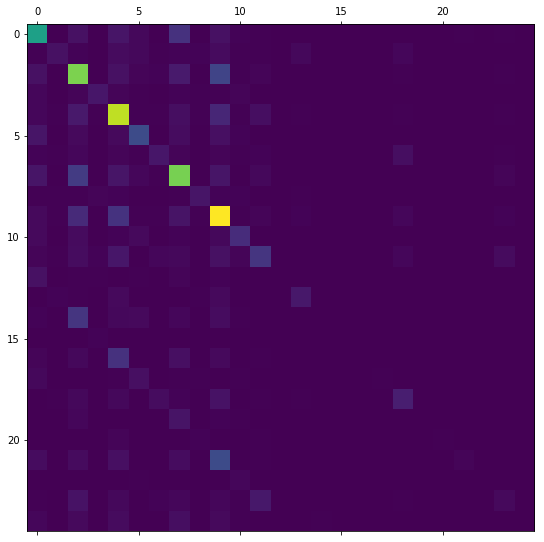

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.matshow(conf_matrix,fignum=0)

In [26]:
class_probs = clf.predict_proba(X)        
print(class_probs.shape)

(59480, 25)


The predictions using the machine learning approach are done in isolation using each beat-synchronous chroma vector individually. We expect that chords last multiple beats so there might be some value in temporally smoothing the sequence of predictions to remove isolated noisy predictions. Let's see if that works. It looks 
like median filtering with a size of 3 has a beneificial effect but with size 5 does not result in an improvement in classification accuracy. This might have to do with the common-duration of 4 beats for chords although we can't tell for sure without further investigation. 


In [29]:
from scipy import signal

print("Classification accuracy :%2.3f"
      % metrics.accuracy_score(y, predicted))

mpredicted = signal.medfilt(predicted, kernel_size = 3)
print("Classification accuracy :%2.3f"
      % metrics.accuracy_score(y, mpredicted))

mpredicted = signal.medfilt(predicted, kernel_size = 5)
print("Classification accuracy :%2.3f"
      % metrics.accuracy_score(y, mpredicted))

Classification accuracy :0.500
Classification accuracy :0.525
Classification accuracy :0.505


A more sophisticated approach to smoothing based on median filtering is to perform smoothing probabilitistically using the viterbi algorithm for predictions. In this case we need a classifier that outputs probababilities of each chord type at each beat based on chroma rather than just the most likely chord type. The viterbi smoothing takes advantage of the chord type transition matrix. Informally this allows the smoothing to adjust depending on the fact that some chord transitions for example from dominant to tonic are more likely than others. The transition matrix encodes probabilities of chord durations indirectly through the diagonal self-transition probabbilities and the off-diagonal elemetns encode transition probabilities. 

Let's see if this helps with improving the classification accuaracy. As can be seen it provides a more significant improvement than the median filtering smoothing. 

We will formalize more these notions when we investigate in more detail Hidden Markov Models (HMMs). 

Classification accuracy :0.543



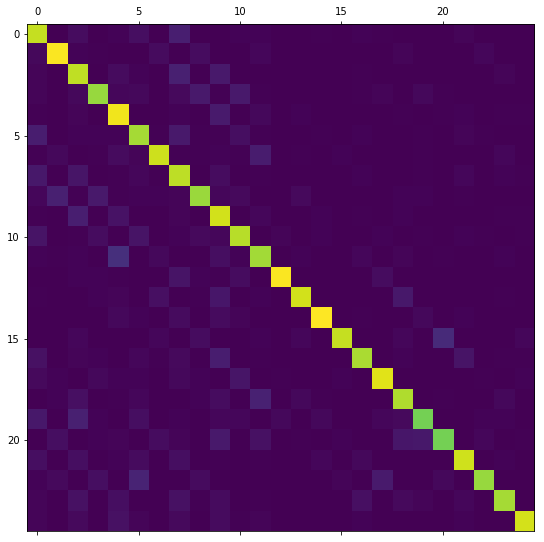

In [31]:
transition_matrix = np.zeros([25, 25])
for k in np.arange(1, len(y)-1):
        i = y[k-1]
        j = y[k]
        transition_matrix[i,j] += 1 
        
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)            

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.matshow(transition_matrix,fignum=0)


vpredicted = librosa.sequence.viterbi_discriminative(class_probs.transpose(),transition_matrix)        

print("Classification accuracy :%2.3f\n" % metrics.accuracy_score(y, vpredicted))

The techniques we explored in this notebook illustrate the basic building blocks of an automatic chord detection system. There are several directions for improving the classification results of our system. These include in no particular order: 

1. More data - the Beatles data set is relatively small and does not capture the typical diversity of a music collection. In addition to other datasets that have chord annotations such as the Billboard dataset it is possible to obtain annotations by using MIDI data to obtain the chord values and then converting the MIDI data to audio to train the classifier. 

2. Another common approach for increasing the amount of data used to train the system is data augmentation. For example it is possible to include all 12 pitch shifts either by pitch shifting the input audio or by cyclically rotating the chromagram representation. 

3. One can perform harmonic-percussive sound source separation and perform the chord detection on the harmonic part to reduce the effect of percussion instruments on the chromagram representation 

4. Many modern automatic chord recognition system use a deep learning architecture for the the chord prediction rather than traditional machine learning techniques 

5.  When using expeanded chord vocabularies there is significant overlap in the representations of different chord types. For example a CMaj7 share three notes with a Cmaj chord. In the traditional approach to training each chord type is treated as a separate class. With structured training it is possible to exploit the structural relationships between chords. 

